<a href="https://colab.research.google.com/github/chuchun2/ATMS597-Project6-GroupB/blob/master/ATMS597_Project6_GroupB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
%pylab inline
import xarray as xr
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from google.colab import drive
drive.mount('/content/drive')

Populating the interactive namespace from numpy and matplotlib
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Set your directory path
YOUR_DIRECTORY = '/content/drive/My Drive/ATMS597 Weather Climate Data Analysis/Module 6/Project 6/'  # Chu-Chun
# YOUR_DIRECTORY = '/content/drive/My Drive/Colab Notebooks/Project_6/' # Jeff

In [0]:
# Load MJO data
MJOIndices_df = pd.read_csv(YOUR_DIRECTORY + 'MJOIndices_JMA_1980to2020.csv', index_col = 'Unnamed: 0')
MJOIndices_df.columns.name = 'Date'
MJOIndices_df

Date,MJOPhase_OLR,MJOLongitude_OLR,MJOAmplitude_OLR,MJOPhase_Chi200,MJOLongitude_Chi200,MJOAmplitude_Chi200
1980-01-01,5,148.6,0.6049,5,175.4,0.5459
1980-01-02,5,164.0,0.6069,6,187.0,0.7355
1980-01-03,5,176.0,0.5613,6,198.4,0.6891
1980-01-04,6,185.2,0.6842,6,191.3,0.7448
1980-01-05,6,199.9,0.8435,6,215.7,0.8425
...,...,...,...,...,...,...
2020-02-15,5,176.4,1.6450,5,180.0,1.6147
2020-02-16,5,171.4,1.7534,5,167.1,1.7944
2020-02-17,5,164.4,1.7153,5,166.2,1.9357
2020-02-18,5,163.8,1.6732,5,172.0,1.8460


In [0]:
# Load Bahia Blanca rainfall data
BB_rainfall = pd.read_csv(YOUR_DIRECTORY + 'ghcn_data.csv')

# Fill in missing days with NaN
idx = pd.date_range('1980-01-01', '2019-12-31')
BB_rainfall.index = pd.to_datetime(BB_rainfall['date'])
BB_rainfall = BB_rainfall.reindex(idx, fill_value = NaN)
BB_rainfall

,date,datatype,station,attributes,value
1980-01-01,1980-01-01,PRCP,GHCND:AR000877500,",,S,",0.0
1980-01-02,1980-01-02,PRCP,GHCND:AR000877500,",,S,",0.0
1980-01-03,1980-01-03,PRCP,GHCND:AR000877500,",,S,",0.0
1980-01-04,1980-01-04,PRCP,GHCND:AR000877500,",,S,",0.0
1980-01-05,1980-01-05,PRCP,GHCND:AR000877500,",,S,",18.0
...,...,...,...,...,...
2019-12-27,NaN,NaN,NaN,NaN,NaN
2019-12-28,2019-12-28,PRCP,GHCND:AR000877500,",,S,",0.0
2019-12-29,NaN,NaN,NaN,NaN,NaN
2019-12-30,2019-12-30,PRCP,GHCND:AR000877500,",,S,",5.1


In [0]:
# Load ERA5 soil moisture data
data1 = xr.open_dataset(YOUR_DIRECTORY + 'ERA5_swvl1.nc')
data2 = xr.open_dataset(YOUR_DIRECTORY + 'ERA5_swvl2.nc')
data2

<xarray.Dataset>
Dimensions:    (latitude: 2, longitude: 2, time: 14610)
Coordinates:
  * longitude  (longitude) float32 -62.25 -62.0
  * latitude   (latitude) float32 -38.5 -38.75
  * time       (time) datetime64[ns] 1980-01-01T12:00:00 ... 2019-12-31T12:00:00
Data variables:
    swvl2      (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-05-03 15:50:32 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [0]:
swvl1_aave = np.mean(swvl1['swvl1'], axis=(1, 2))
swvl2_aave = np.mean(swvl2['swvl2'], axis=(1, 2))

In [0]:
swvl1_aave = np.mean(data1['swvl1'], axis=(1, 2))
swvl2_aave = np.mean(data2['swvl2'], axis=(1, 2))
ERA5_soil_moisture1_df = swvl1_aave.to_dataframe()
ERA5_soil_moisture2_df = swvl2_aave.to_dataframe()
ERA5_soil_moisture1_df.index = ERA5_soil_moisture1_df.index.strftime('%Y-%m-%d')
ERA5_soil_moisture2_df.index = ERA5_soil_moisture2_df.index.strftime('%Y-%m-%d')
ERA5_soil_moisture2_df

,swvl2
time,
1980-01-01,0.205773
1980-01-02,0.198426
1980-01-03,0.192707
1980-01-04,0.179462
1980-01-05,0.175685
...,...
2019-12-27,0.143121
2019-12-28,0.142428
2019-12-29,0.140815


In [0]:
# Add Rainfall data in the dataframe
MJOIndices_df['BahiaBlanca_Rainfall'] = BB_rainfall['value']

# Add ERA5 soil moisture data in the dataframe
MJOIndices_df['ERA5_Soil_Moisture_Lev1'] = ERA5_soil_moisture1_df
MJOIndices_df['ERA5_Soil_Moisture_Lev2'] = ERA5_soil_moisture2_df

# Removing rows for 2020
MJOIndices_df.index = pd.to_datetime(MJOIndices_df.index)
MJOIndices_df['Year'] = MJOIndices_df.index.year
MJOIndices_df = MJOIndices_df[MJOIndices_df['Year'] != 2020]
MJOIndices_df = MJOIndices_df.drop(columns = 'Year')

# Change column order
MJOIndices_df = MJOIndices_df[['BahiaBlanca_Rainfall', 'MJOPhase_OLR', 'MJOLongitude_OLR', 'MJOAmplitude_OLR',
                               'MJOPhase_Chi200', 'MJOLongitude_Chi200', 'MJOAmplitude_Chi200',
                               'ERA5_Soil_Moisture_Lev1', 'ERA5_Soil_Moisture_Lev2']]
MJOIndices_df.dropna()
#MJOIndices_df.to_csv(YOUR_DIRECTORY + 'SouthAmericanRainfall_MJOIndices_v1.csv')

In [34]:
# Load saved combined data
MJOIndices_df = pd.read_csv(YOUR_DIRECTORY + 'SouthAmericanRainfall_MJOIndices_v1.csv', index_col = 'Unnamed: 0')
MJOIndices_df.columns.name = 'Date'
MJOIndices_df

Date,BahiaBlanca_Rainfall,MJOPhase_OLR,MJOLongitude_OLR,MJOAmplitude_OLR,MJOPhase_Chi200,MJOLongitude_Chi200,MJOAmplitude_Chi200,ERA5_Soil_Moisture_Lev1,ERA5_Soil_Moisture_Lev2
1980-01-01,0.0,5,148.6,0.6049,5,175.4,0.5459,0.209384,0.205773
1980-01-02,0.0,5,164.0,0.6069,6,187.0,0.7355,0.181627,0.198426
1980-01-03,0.0,5,176.0,0.5613,6,198.4,0.6891,0.175117,0.192707
1980-01-04,0.0,6,185.2,0.6842,6,191.3,0.7448,0.150012,0.179462
1980-01-05,18.0,6,199.9,0.8435,6,215.7,0.8425,0.191845,0.175685
...,...,...,...,...,...,...,...,...,...
2019-12-27,NaN,6,219.4,1.1587,6,217.9,1.2077,0.128531,0.143121
2019-12-28,0.0,7,247.8,0.8633,7,252.5,0.9382,0.127302,0.142428
2019-12-29,NaN,7,267.5,0.8687,8,274.8,0.9158,0.124223,0.140815
2019-12-30,5.1,8,277.6,0.6520,8,291.6,0.7442,0.162332,0.140790


In [35]:
# clean the data
data = MJOIndices_df.dropna()
data

Date,BahiaBlanca_Rainfall,MJOPhase_OLR,MJOLongitude_OLR,MJOAmplitude_OLR,MJOPhase_Chi200,MJOLongitude_Chi200,MJOAmplitude_Chi200,ERA5_Soil_Moisture_Lev1,ERA5_Soil_Moisture_Lev2
1980-01-01,0.0,5,148.6,0.6049,5,175.4,0.5459,0.209384,0.205773
1980-01-02,0.0,5,164.0,0.6069,6,187.0,0.7355,0.181627,0.198426
1980-01-03,0.0,5,176.0,0.5613,6,198.4,0.6891,0.175117,0.192707
1980-01-04,0.0,6,185.2,0.6842,6,191.3,0.7448,0.150012,0.179462
1980-01-05,18.0,6,199.9,0.8435,6,215.7,0.8425,0.191845,0.175685
...,...,...,...,...,...,...,...,...,...
2019-12-20,2.0,4,116.2,0.5752,5,139.0,1.0510,0.235895,0.146751
2019-12-21,0.0,5,136.8,0.5292,5,148.3,1.3558,0.205727,0.149838
2019-12-28,0.0,7,247.8,0.8633,7,252.5,0.9382,0.127302,0.142428
2019-12-30,5.1,8,277.6,0.6520,8,291.6,0.7442,0.162332,0.140790


In [0]:
# Separate observation precipitation and features
y = data['BahiaBlanca_Rainfall'].to_numpy()
X = data.drop(columns = ['BahiaBlanca_Rainfall']).to_numpy()

In [0]:
# Split the data into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [38]:
# Linear regression model
model_LinearRegression = LinearRegression()
model_LinearRegression.fit(train_X, train_y)

LinearRegression_predict_y = model_LinearRegression.predict(test_X)
rmse_LinearRegression = sqrt(mean_squared_error(test_y, LinearRegression_predict_y))
print('RMSE of linear regression model: ', rmse_LinearRegression)

RMSE of linear regression model:  8.18154066328215


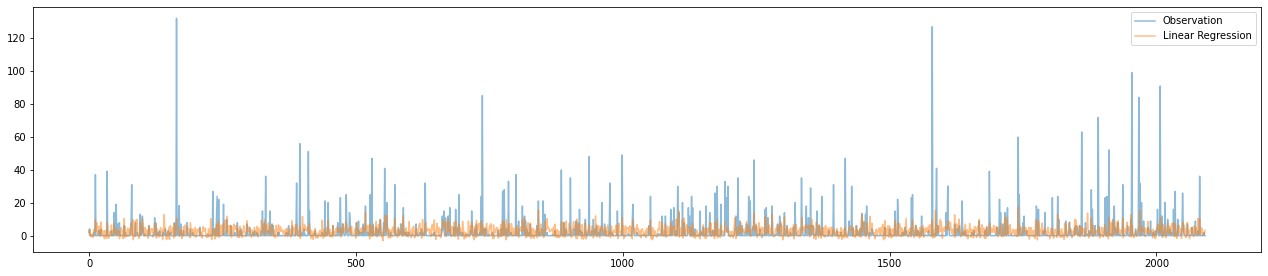

In [39]:
# Plot testing data and model prediction
plt.figure(figsize=(22, 4.5))
plt.plot(test_y, alpha=0.5, label='Observation')
plt.plot(LinearRegression_predict_y, alpha=0.5, label='Linear Regression')
plt.legend()
plt.show()